In [1]:
! export PYTHONPATH="$PYTHONPATH:$HOME/generic_implementation/POISEVAE"

In [2]:
import glob 

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F  # activation function
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

from joint_dataset import CUB
from POISEVAE import POISEVAE # Remember to do export PYTHONPATH ...

In [3]:
DATA_PATH = 'data'

In [4]:
class EncImg(nn.Module):
    def __init__(self, latent_dim, input_dim=2048):
        super(EncImg, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        n = (input_dim, 1024, 512, 256)
        li = []
        for i in range(len(n)-1):
            li += [nn.Linear(n[i], n[i+1]), nn.ELU(inplace=True)]
        self.enc = nn.Sequential(*li)
        self.enc_mu = nn.Linear(256, latent_dim)
        self.enc_var = nn.Linear(256, latent_dim)
        
    def forward(self, x):
        x = self.enc(x)
        mu = self.enc_mu(x)
        log_var = self.enc_var(x)
        return mu, log_var

class DecImg(nn.Module):
    def __init__(self, latent_dim, output_dim=2048):
        super(DecImg, self).__init__()  
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        
        n = (output_dim, 1024, 512, 256)
        li = [nn.Linear(latent_dim, 256)]
        for i in range(len(n)-1, 0, -1):
            li += [nn.ELU(inplace=True), nn.Linear(n[i], n[i-1])]
        self.dec = nn.Sequential(*li)
        
    def forward(self, z):
        return self.dec(z)

In [5]:
class EncTxt(nn.Module):
    def __init__(self, vocab_size, latent_dim, emb_dim=128):
        super(EncTxt, self).__init__()
        self.vocab_size = vocab_size
        self.latent_dim = latent_dim
        self.emb_dim = emb_dim
        
        # 0 is for the excluded words and does not contribute to gradient
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        n_channels = (1, 32, 64, 128, 256, 512)
        kernels = (4, 4, 4, (1, 4), (1, 4))
        strides = (2, 2, 2, (1, 2), (1, 2))
        paddings = (1, 1, 1, (0, 1), (0, 1))
        li = []
        for i, (n, k, s, p) in enumerate(zip(n_channels[1:], kernels, strides, paddings), 1):
            li += [nn.Conv2d(n_channels[i-1], n, kernel_size=k, stride=s, padding=p), 
                   nn.BatchNorm2d(n), nn.ReLU(inplace=True)]
            
        self.enc = nn.Sequential(*li)
        self.enc_mu = nn.Conv2d(512, latent_dim, kernel_size=4, stride=1, padding=0)
        self.enc_var = nn.Conv2d(512, latent_dim, kernel_size=4, stride=1, padding=0)
        
    def forward(self, x):
        x = self.emb(x.long()).unsqueeze(1) # add channel dim
        x = self.enc(x)
        mu = self.enc_mu(x).squeeze()
        log_var = self.enc_var(x).squeeze()
        return mu, log_var

class DecTxt(nn.Module):
    def __init__(self, vocab_size, latent_dim, emb_dim=128, txt_len=32):
        super(DecTxt, self).__init__()
        self.vocab_size = vocab_size
        self.latent_dim = latent_dim
        self.emb_dim = emb_dim
        self.txt_len = txt_len
        
        n_channels = (1, 32, 64, 128, 256, 512, latent_dim)
        kernels = (4, 4, 4, (1, 4), (1, 4), 4)
        strides = (2, 2, 2, (1, 2), (1, 2), 1)
        paddings = (1, 1, 1, (0, 1), (0, 1), 0)
        li = []
        for i, (n, k, s, p) in enumerate(zip(n_channels[1:], kernels, strides, paddings), 1):
            li = [nn.ConvTranspose2d(n, n_channels[i-1], kernel_size=k, stride=s, padding=p), 
                  nn.BatchNorm2d(n_channels[i-1]), nn.ReLU(inplace=True)] + li
            
        # No batchnorm at the first and last block
        del li[-2]
        del li[1]
        self.dec = nn.Sequential(*li)
        self.anti_emb = nn.Linear(emb_dim, vocab_size)
        
    def forward(self, z, argmax=False):
        z = self.dec(z)
        z = self.anti_emb(z.view(-1, self.emb_dim))
        z = z.view(-1, self.txt_len, self.vocab_size) # batch x txt len x vocab size
        if argmax:
            z = z.argmax(-1).float()
        return z

In [6]:
tx = lambda data: torch.Tensor(data)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
CUB_train = CUB(DATA_PATH, DATA_PATH, 'train', device, tx, return_idx=False)
CUB_test = CUB(DATA_PATH, DATA_PATH, 'test', device, tx, return_idx=True)

In [9]:
vocab_size, txt_len = CUB_train.CUBtxt.vocab_size, CUB_train.CUBtxt.max_sequence_length
vocab_size, txt_len

(1590, 32)

In [10]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(CUB_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(CUB_test, batch_size=batch_size, shuffle=True)
len(train_loader), len(test_loader)

(1384, 459)

In [11]:
enc_img = EncImg(128).to(device)
dec_img = DecImg(128).to(device)
enc_txt = EncTxt(vocab_size, 128).to(device)
dec_txt = DecTxt(vocab_size, 128).to(device)

def CELoss(input, target):
    batch_size = target.shape[0]
    input, target = input.view(-1, vocab_size), target.view(-1).to(torch.long)
    loss = nn.functional.cross_entropy(input, target, reduction='sum') #/ batch_size
    return loss
    
def MSELoss(input, target):
    loss = nn.functional.mse_loss(input, target, reduction='sum') #/ batch_size
    return loss
    
vae = POISEVAE([enc_img, enc_txt], [dec_img, dec_txt], [MSELoss, CELoss], 
               latent_dims=[128, (128, 1, 1)]).to(device)

In [12]:
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

In [13]:
def train(model, joint_dataloader, epoch):
    model.train()
    running_loss = 0.0
    running_rec1 = 0.0
    running_rec2 = 0.0
    running_kld  = 0.0
    running_loss = 0.0
    for i, (img, txt) in enumerate(tqdm(joint_dataloader)):
        optimizer.zero_grad()
        
        results = model([img.to(device), txt[0].to(device)])
        z_posterior, mu, var = results['z'], results['mu'], results['var']
        reconstruction = results['x_rec']
        total_loss, rec_loss, KLD = results['total_loss'], results['rec_losses'], results['KL_loss']
        
        running_rec1 += rec_loss[0].item()
        running_rec2 += rec_loss[1].item()
        running_kld  += KLD.item()
        running_loss += total_loss.item() #.item converts tensor with one element to number
        total_loss.backward() #.backward
        optimizer.step() #.step one learning step
    train_loss = running_loss / (len(joint_dataloader.dataset))
    rec1_loss = running_rec1 / (len(joint_dataloader.dataset))
    rec2_loss = running_rec2 / (len(joint_dataloader.dataset))
    kld_loss = running_kld / (len(joint_dataloader.dataset))   
    return train_loss, rec1_loss, rec2_loss, kld_loss

In [14]:
def test(model, joint_dataloader, epoch):
    latent1 = []
    latent2 = []
    mu1_data = []
    mu2_data = []
    var1_data = []
    var2_data = []
    
    model.eval()
    running_loss = 0.0
    running_rec1 = 0.0
    running_rec2 = 0.0
    running_kld  = 0.0
    running_loss = 0.0
    with torch.no_grad():
        for i, (img, txt, _) in enumerate(tqdm(joint_dataloader)):
            results = model([img.to(device), txt[0].to(device)])
            z_posterior, mu, var = results['z'], results['mu'], results['var']
            reconstruction = results['x_rec']
            total_loss, rec_loss, KLD = results['total_loss'], results['rec_losses'], results['KL_loss']

            running_loss += total_loss.item()
            running_rec1 += rec_loss[0].item()
            running_rec2 += rec_loss[0].item()
            running_kld  += KLD.item()    
            
            latent1.append(z_posterior[0])
            latent2.append(z_posterior[1])
            mu1_data.extend(mu[0].cpu().numpy())
            mu2_data.extend(mu[1].cpu().numpy())
            var1_data.extend(var[0].cpu().numpy())
            var2_data.extend(var[1].cpu().numpy())
    test_loss = running_loss / (len(joint_dataloader.dataset))
    rec1_loss = running_rec1 / (len(joint_dataloader.dataset))
    rec2_loss = running_rec2 / (len(joint_dataloader.dataset))
    kld_loss = running_kld / (len(joint_dataloader.dataset))
    latent1 = torch.vstack(latent1).cpu().numpy()
    latent2  = torch.vstack(latent2).cpu().numpy()
    return test_loss, rec1_loss, rec2_loss, kld_loss, \
           latent1, latent2, mu1_data, mu2_data, var1_data, var2_data

In [15]:
def save_checkpoint(model, optimizer, save_path, epoch):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, save_path)

def load_checkpoint(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    return model, optimizer, epoch

In [16]:
PATH = 'CUB_training_tentative/'

In [17]:
try:
    vae, optimizer, epoch = load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
except:
    epoch = 0

In [18]:
train_loss = []
test_loss = []
epochs = 100 + epoch
for epoch in range(epoch, epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_losses = train(vae, train_loader, epoch)
    train_loss.append(train_epoch_losses)
    ret = test(vae, test_loader, epoch)
    test_epoch_losses = ret[:4]
    latent1, latent2, mu1_data, mu2_data, var1_data, var2_data = ret[4:]
    test_loss.append(test_epoch_losses)
    print(f"Train Loss: %.4f\n\tRec: %.4f, %.4f\n\tKLD Loss %.4f" % train_epoch_losses)
    print(f"Test Loss: %.4f\n\tRec: %.4f, %.4f\n\tKLD Loss %.4f" % test_epoch_losses)
    if epoch % 10 == 0 and epoch > 0:
        save_checkpoint(vae, optimizer, PATH + 'training_%d.pt' % epoch, epoch)
train_loss = np.array(train_loss).T
test_loss = np.array(test_loss).T

Epoch 1 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.50it/s]


Train Loss: 247.0405
	Rec: 194.9320, 58.8367
	KLD Loss -6.7283
Test Loss: 211.5855
	Rec: 166.9863, 166.9863
	KLD Loss -7.4806
Epoch 2 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.36it/s]


Train Loss: 195.5359
	Rec: 150.5834, 49.7574
	KLD Loss -4.8050
Test Loss: 190.0393
	Rec: 144.3336, 144.3336
	KLD Loss -2.3453
Epoch 3 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.51it/s]


Train Loss: 178.7061
	Rec: 133.9500, 46.2063
	KLD Loss -1.4502
Test Loss: 179.8043
	Rec: 134.8620, 134.8620
	KLD Loss 0.2955
Epoch 4 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.41it/s]


Train Loss: 167.0199
	Rec: 124.0085, 43.2104
	KLD Loss -0.1990
Test Loss: 169.7990
	Rec: 127.0287, 127.0287
	KLD Loss 0.7097
Epoch 5 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.39it/s]


Train Loss: 158.2378
	Rec: 117.2259, 40.7957
	KLD Loss 0.2161
Test Loss: 163.2195
	Rec: 121.9930, 121.9930
	KLD Loss 0.8897
Epoch 6 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.29it/s]


Train Loss: 151.7444
	Rec: 112.2099, 39.1696
	KLD Loss 0.3649
Test Loss: 159.3131
	Rec: 118.4691, 118.4691
	KLD Loss 1.6861
Epoch 7 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.38it/s]


Train Loss: 146.8269
	Rec: 108.6124, 37.9811
	KLD Loss 0.2333
Test Loss: 153.8027
	Rec: 115.9290, 115.9290
	KLD Loss -0.0209
Epoch 8 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.30it/s]


Train Loss: 143.0699
	Rec: 105.7150, 37.0565
	KLD Loss 0.2984
Test Loss: 151.4932
	Rec: 113.4264, 113.4264
	KLD Loss 0.5566
Epoch 9 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.40it/s]


Train Loss: 139.5256
	Rec: 103.1191, 36.2943
	KLD Loss 0.1122
Test Loss: 148.3767
	Rec: 111.8644, 111.8644
	KLD Loss -0.2571
Epoch 10 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.37it/s]


Train Loss: 136.9193
	Rec: 101.1685, 35.6377
	KLD Loss 0.1131
Test Loss: 146.8027
	Rec: 110.4501, 110.4501
	KLD Loss 0.2516
Epoch 11 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.37it/s]


Train Loss: 134.7382
	Rec: 99.5726, 35.0320
	KLD Loss 0.1336
Test Loss: 145.9065
	Rec: 109.8688, 109.8688
	KLD Loss 0.4217
Epoch 12 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.48it/s]


Train Loss: 132.9102
	Rec: 98.2976, 34.5079
	KLD Loss 0.1047
Test Loss: 145.6418
	Rec: 109.7678, 109.7678
	KLD Loss 0.5088
Epoch 13 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.35it/s]


Train Loss: 131.0991
	Rec: 97.1157, 34.0376
	KLD Loss -0.0542
Test Loss: 144.6288
	Rec: 108.9024, 108.9024
	KLD Loss 0.8034
Epoch 14 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.28it/s]


Train Loss: 129.5598
	Rec: 95.8824, 33.6176
	KLD Loss 0.0598
Test Loss: 143.6735
	Rec: 108.1122, 108.1122
	KLD Loss 0.8225
Epoch 15 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.34it/s]


Train Loss: 127.8700
	Rec: 94.7824, 33.1751
	KLD Loss -0.0875
Test Loss: 142.3749
	Rec: 107.4974, 107.4974
	KLD Loss 0.4903
Epoch 16 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.17it/s]


Train Loss: 126.5960
	Rec: 93.8470, 32.7693
	KLD Loss -0.0203
Test Loss: 141.3181
	Rec: 106.7073, 106.7073
	KLD Loss 0.6673
Epoch 17 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.36it/s]


Train Loss: 125.3480
	Rec: 92.9207, 32.4308
	KLD Loss -0.0035
Test Loss: 141.3518
	Rec: 106.4966, 106.4966
	KLD Loss 1.2179
Epoch 18 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.26it/s]


Train Loss: 124.1310
	Rec: 92.0391, 32.0649
	KLD Loss 0.0270
Test Loss: 140.2599
	Rec: 106.2392, 106.2392
	KLD Loss 0.4714
Epoch 19 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.40it/s]


Train Loss: 122.9011
	Rec: 91.1915, 31.7820
	KLD Loss -0.0724
Test Loss: 140.4223
	Rec: 105.5698, 105.5698
	KLD Loss 1.4309
Epoch 20 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.30it/s]


Train Loss: 121.7626
	Rec: 90.3001, 31.4610
	KLD Loss 0.0015
Test Loss: 140.5065
	Rec: 105.9634, 105.9634
	KLD Loss 1.4112
Epoch 21 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.23it/s]


Train Loss: 120.7495
	Rec: 89.5876, 31.2262
	KLD Loss -0.0644
Test Loss: 139.4195
	Rec: 105.5489, 105.5489
	KLD Loss 0.8870
Epoch 22 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.27it/s]


Train Loss: 119.7758
	Rec: 88.9143, 30.9612
	KLD Loss -0.0997
Test Loss: 140.6192
	Rec: 105.9532, 105.9532
	KLD Loss 1.7744
Epoch 23 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.29it/s]


Train Loss: 118.9170
	Rec: 88.2534, 30.7230
	KLD Loss -0.0593
Test Loss: 139.4094
	Rec: 106.0649, 106.0649
	KLD Loss 0.6679
Epoch 24 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.27it/s]


Train Loss: 118.1093
	Rec: 87.6798, 30.4978
	KLD Loss -0.0683
Test Loss: 138.7009
	Rec: 105.4511, 105.4511
	KLD Loss 0.6490
Epoch 25 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.43it/s]


Train Loss: 117.2429
	Rec: 87.0750, 30.2640
	KLD Loss -0.0962
Test Loss: 139.9640
	Rec: 105.7277, 105.7277
	KLD Loss 1.7036
Epoch 26 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.35it/s]


Train Loss: 116.5271
	Rec: 86.4403, 30.0875
	KLD Loss -0.0007
Test Loss: 138.9960
	Rec: 105.7101, 105.7101
	KLD Loss 1.0820
Epoch 27 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.34it/s]


Train Loss: 115.6451
	Rec: 85.9193, 29.8613
	KLD Loss -0.1355
Test Loss: 139.3469
	Rec: 106.0706, 106.0706
	KLD Loss 0.9654
Epoch 28 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.26it/s]


Train Loss: 115.0256
	Rec: 85.3598, 29.6448
	KLD Loss 0.0211
Test Loss: 138.9267
	Rec: 105.7498, 105.7498
	KLD Loss 1.0005
Epoch 29 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.37it/s]


Train Loss: 114.2580
	Rec: 84.8655, 29.5068
	KLD Loss -0.1143
Test Loss: 139.0248
	Rec: 105.9297, 105.9297
	KLD Loss 0.9644
Epoch 30 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.26it/s]


Train Loss: 113.5696
	Rec: 84.3329, 29.2843
	KLD Loss -0.0477
Test Loss: 140.0870
	Rec: 106.3666, 106.3666
	KLD Loss 1.7335
Epoch 31 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.17it/s]


Train Loss: 112.8004
	Rec: 83.8372, 29.1104
	KLD Loss -0.1472
Test Loss: 139.3384
	Rec: 105.6075, 105.6075
	KLD Loss 1.8952
Epoch 32 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.25it/s]


Train Loss: 112.2447
	Rec: 83.3073, 28.9373
	KLD Loss 0.0000
Test Loss: 139.6288
	Rec: 106.2332, 106.2332
	KLD Loss 1.6780
Epoch 33 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.42it/s]


Train Loss: 111.4125
	Rec: 82.7368, 28.7783
	KLD Loss -0.1026
Test Loss: 138.5356
	Rec: 106.1585, 106.1585
	KLD Loss 0.6071
Epoch 34 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.34it/s]


Train Loss: 110.7607
	Rec: 82.2426, 28.6017
	KLD Loss -0.0837
Test Loss: 138.6624
	Rec: 105.8039, 105.8039
	KLD Loss 1.1619
Epoch 35 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.10it/s]


Train Loss: 110.0881
	Rec: 81.8277, 28.4291
	KLD Loss -0.1687
Test Loss: 138.6396
	Rec: 105.7538, 105.7538
	KLD Loss 1.3363
Epoch 36 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.31it/s]


Train Loss: 109.4720
	Rec: 81.3064, 28.2838
	KLD Loss -0.1183
Test Loss: 138.6392
	Rec: 106.5326, 106.5326
	KLD Loss 0.5837
Epoch 37 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.29it/s]


Train Loss: 108.9416
	Rec: 80.9315, 28.1356
	KLD Loss -0.1255
Test Loss: 140.5516
	Rec: 106.8179, 106.8179
	KLD Loss 2.2960
Epoch 38 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.22it/s]


Train Loss: 108.4050
	Rec: 80.5538, 27.9803
	KLD Loss -0.1290
Test Loss: 139.4373
	Rec: 106.2920, 106.2920
	KLD Loss 1.7565
Epoch 39 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.34it/s]


Train Loss: 107.7143
	Rec: 80.0905, 27.8314
	KLD Loss -0.2076
Test Loss: 139.5654
	Rec: 106.5887, 106.5887
	KLD Loss 1.6145
Epoch 40 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.35it/s]


Train Loss: 107.1602
	Rec: 79.6961, 27.6606
	KLD Loss -0.1965
Test Loss: 139.9564
	Rec: 106.8910, 106.8910
	KLD Loss 1.7138
Epoch 41 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.27it/s]


Train Loss: 106.9694
	Rec: 79.4596, 27.5482
	KLD Loss -0.0384
Test Loss: 140.6314
	Rec: 107.3766, 107.3766
	KLD Loss 2.0108
Epoch 42 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.32it/s]


Train Loss: 106.2121
	Rec: 78.8974, 27.3879
	KLD Loss -0.0732
Test Loss: 140.1209
	Rec: 107.0032, 107.0032
	KLD Loss 1.9123
Epoch 43 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.39it/s]


Train Loss: 105.6354
	Rec: 78.5862, 27.2357
	KLD Loss -0.1865
Test Loss: 141.9115
	Rec: 107.5773, 107.5773
	KLD Loss 3.0488
Epoch 44 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.30it/s]


Train Loss: 105.1839
	Rec: 78.1350, 27.1186
	KLD Loss -0.0697
Test Loss: 140.6842
	Rec: 107.7370, 107.7370
	KLD Loss 1.7521
Epoch 45 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.25it/s]


Train Loss: 104.5434
	Rec: 77.8113, 26.9719
	KLD Loss -0.2398
Test Loss: 141.1884
	Rec: 108.0652, 108.0652
	KLD Loss 1.9701
Epoch 46 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.38it/s]


Train Loss: 104.2286
	Rec: 77.4815, 26.8594
	KLD Loss -0.1123
Test Loss: 140.8954
	Rec: 107.9583, 107.9583
	KLD Loss 1.7774
Epoch 47 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.18it/s]


Train Loss: 103.6138
	Rec: 77.0867, 26.7311
	KLD Loss -0.2040
Test Loss: 140.8609
	Rec: 107.9532, 107.9532
	KLD Loss 1.9297
Epoch 48 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.15it/s]


Train Loss: 103.2090
	Rec: 76.8062, 26.6178
	KLD Loss -0.2150
Test Loss: 141.0711
	Rec: 108.2471, 108.2471
	KLD Loss 1.6597
Epoch 49 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.25it/s]


Train Loss: 102.7046
	Rec: 76.4338, 26.4802
	KLD Loss -0.2094
Test Loss: 141.2717
	Rec: 108.3707, 108.3707
	KLD Loss 1.8034
Epoch 50 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.41it/s]


Train Loss: 102.1972
	Rec: 76.0705, 26.3424
	KLD Loss -0.2157
Test Loss: 141.2014
	Rec: 108.8574, 108.8574
	KLD Loss 1.2394
Epoch 51 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.34it/s]


Train Loss: 101.8459
	Rec: 75.7620, 26.2298
	KLD Loss -0.1460
Test Loss: 141.0774
	Rec: 108.6115, 108.6115
	KLD Loss 1.3239
Epoch 52 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.28it/s]


Train Loss: 101.4240
	Rec: 75.4863, 26.1307
	KLD Loss -0.1930
Test Loss: 141.5213
	Rec: 108.8812, 108.8812
	KLD Loss 1.6315
Epoch 53 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.23it/s]


Train Loss: 101.0243
	Rec: 75.1657, 25.9954
	KLD Loss -0.1368
Test Loss: 142.2329
	Rec: 109.4902, 109.4902
	KLD Loss 1.6605
Epoch 54 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.35it/s]


Train Loss: 100.4939
	Rec: 74.8476, 25.9073
	KLD Loss -0.2610
Test Loss: 145.2325
	Rec: 110.0455, 110.0455
	KLD Loss 4.2673
Epoch 55 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.25it/s]


Train Loss: 100.0422
	Rec: 74.5061, 25.7781
	KLD Loss -0.2419
Test Loss: 144.2210
	Rec: 109.4796, 109.4796
	KLD Loss 3.7824
Epoch 56 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.34it/s]


Train Loss: 99.8160
	Rec: 74.2554, 25.6684
	KLD Loss -0.1077
Test Loss: 143.5270
	Rec: 110.4639, 110.4639
	KLD Loss 1.9873
Epoch 57 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.34it/s]


Train Loss: 99.2085
	Rec: 73.9847, 25.5505
	KLD Loss -0.3267
Test Loss: 143.1167
	Rec: 110.1914, 110.1914
	KLD Loss 2.0277
Epoch 58 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.13it/s]


Train Loss: 98.9827
	Rec: 73.7146, 25.4603
	KLD Loss -0.1921
Test Loss: 143.1322
	Rec: 109.9043, 109.9043
	KLD Loss 2.0639
Epoch 59 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.35it/s]


Train Loss: 98.5285
	Rec: 73.3941, 25.3714
	KLD Loss -0.2371
Test Loss: 144.0919
	Rec: 110.1807, 110.1807
	KLD Loss 2.8853
Epoch 60 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.25it/s]


Train Loss: 98.2434
	Rec: 73.0643, 25.2572
	KLD Loss -0.0781
Test Loss: 144.0166
	Rec: 110.7637, 110.7637
	KLD Loss 2.1918
Epoch 61 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.40it/s]


Train Loss: 97.7210
	Rec: 72.8364, 25.1355
	KLD Loss -0.2509
Test Loss: 143.6593
	Rec: 110.5681, 110.5681
	KLD Loss 1.9837
Epoch 62 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.31it/s]


Train Loss: 97.3425
	Rec: 72.5733, 25.0394
	KLD Loss -0.2702
Test Loss: 144.7689
	Rec: 111.0489, 111.0489
	KLD Loss 2.6486
Epoch 63 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.34it/s]


Train Loss: 97.0679
	Rec: 72.2361, 24.9709
	KLD Loss -0.1391
Test Loss: 144.9237
	Rec: 111.4714, 111.4714
	KLD Loss 2.4048
Epoch 64 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.27it/s]


Train Loss: 96.5301
	Rec: 71.9701, 24.8602
	KLD Loss -0.3002
Test Loss: 144.8021
	Rec: 111.2898, 111.2898
	KLD Loss 2.4548
Epoch 65 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.37it/s]


Train Loss: 96.3029
	Rec: 71.7401, 24.7583
	KLD Loss -0.1954
Test Loss: 144.3871
	Rec: 111.0665, 111.0665
	KLD Loss 2.3735
Epoch 66 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.28it/s]


Train Loss: 95.8477
	Rec: 71.4517, 24.6929
	KLD Loss -0.2969
Test Loss: 145.4362
	Rec: 111.8414, 111.8414
	KLD Loss 2.6043
Epoch 67 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.25it/s]


Train Loss: 95.4183
	Rec: 71.1859, 24.5728
	KLD Loss -0.3404
Test Loss: 145.5911
	Rec: 111.9957, 111.9957
	KLD Loss 2.6079
Epoch 68 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.33it/s]


Train Loss: 95.0335
	Rec: 70.8839, 24.4910
	KLD Loss -0.3414
Test Loss: 146.0617
	Rec: 112.5409, 112.5409
	KLD Loss 2.4185
Epoch 69 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.24it/s]


Train Loss: 94.8893
	Rec: 70.6413, 24.3961
	KLD Loss -0.1481
Test Loss: 145.4110
	Rec: 111.9995, 111.9995
	KLD Loss 2.3454
Epoch 70 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.28it/s]


Train Loss: 94.4634
	Rec: 70.3780, 24.3078
	KLD Loss -0.2223
Test Loss: 145.1322
	Rec: 112.2387, 112.2387
	KLD Loss 1.9459
Epoch 71 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.26it/s]


Train Loss: 94.0473
	Rec: 70.1137, 24.2192
	KLD Loss -0.2855
Test Loss: 146.1872
	Rec: 112.5172, 112.5172
	KLD Loss 2.4273
Epoch 72 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.32it/s]


Train Loss: 93.7912
	Rec: 69.8644, 24.1196
	KLD Loss -0.1928
Test Loss: 147.1687
	Rec: 112.5326, 112.5326
	KLD Loss 3.3391
Epoch 73 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.40it/s]


Train Loss: 93.4060
	Rec: 69.6002, 24.0405
	KLD Loss -0.2346
Test Loss: 147.7103
	Rec: 113.0054, 113.0054
	KLD Loss 3.4326
Epoch 74 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.27it/s]


Train Loss: 92.9340
	Rec: 69.2875, 23.9685
	KLD Loss -0.3220
Test Loss: 147.4562
	Rec: 113.3185, 113.3185
	KLD Loss 3.0107
Epoch 75 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.20it/s]


Train Loss: 92.7542
	Rec: 69.0581, 23.8863
	KLD Loss -0.1903
Test Loss: 147.9131
	Rec: 113.7512, 113.7512
	KLD Loss 2.8928
Epoch 76 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.33it/s]


Train Loss: 92.3911
	Rec: 68.7974, 23.8149
	KLD Loss -0.2213
Test Loss: 146.6242
	Rec: 113.1802, 113.1802
	KLD Loss 2.4054
Epoch 77 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.21it/s]


Train Loss: 92.0103
	Rec: 68.5501, 23.7380
	KLD Loss -0.2778
Test Loss: 147.8404
	Rec: 114.0463, 114.0463
	KLD Loss 2.5166
Epoch 78 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.42it/s]


Train Loss: 91.5657
	Rec: 68.2964, 23.6400
	KLD Loss -0.3707
Test Loss: 148.2599
	Rec: 114.0253, 114.0253
	KLD Loss 2.8981
Epoch 79 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.36it/s]


Train Loss: 91.3787
	Rec: 68.0787, 23.5534
	KLD Loss -0.2535
Test Loss: 148.3102
	Rec: 114.5261, 114.5261
	KLD Loss 2.4790
Epoch 80 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.27it/s]


Train Loss: 90.9272
	Rec: 67.8197, 23.4503
	KLD Loss -0.3429
Test Loss: 148.0294
	Rec: 113.9381, 113.9381
	KLD Loss 2.6728
Epoch 81 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.37it/s]


Train Loss: 90.6157
	Rec: 67.5801, 23.3809
	KLD Loss -0.3453
Test Loss: 149.4584
	Rec: 114.4260, 114.4260
	KLD Loss 3.5971
Epoch 82 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.36it/s]


Train Loss: 90.4262
	Rec: 67.3505, 23.3154
	KLD Loss -0.2396
Test Loss: 148.5171
	Rec: 114.3469, 114.3469
	KLD Loss 2.7056
Epoch 83 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.27it/s]


Train Loss: 89.9380
	Rec: 67.0763, 23.2675
	KLD Loss -0.4057
Test Loss: 148.6607
	Rec: 114.2632, 114.2632
	KLD Loss 2.8713
Epoch 84 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.20it/s]


Train Loss: 89.6739
	Rec: 66.8360, 23.1420
	KLD Loss -0.3041
Test Loss: 148.9951
	Rec: 114.6216, 114.6216
	KLD Loss 2.9473
Epoch 85 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.26it/s]


Train Loss: 89.3619
	Rec: 66.6286, 23.0902
	KLD Loss -0.3569
Test Loss: 149.3011
	Rec: 115.3660, 115.3660
	KLD Loss 2.4412
Epoch 86 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.26it/s]


Train Loss: 89.0916
	Rec: 66.4086, 23.0036
	KLD Loss -0.3206
Test Loss: 150.9673
	Rec: 114.8672, 114.8672
	KLD Loss 4.4184
Epoch 87 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.21it/s]


Train Loss: 88.6527
	Rec: 66.0946, 22.9494
	KLD Loss -0.3913
Test Loss: 149.8546
	Rec: 115.5187, 115.5187
	KLD Loss 2.8825
Epoch 88 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.27it/s]


Train Loss: 88.3440
	Rec: 65.8609, 22.8772
	KLD Loss -0.3941
Test Loss: 149.9564
	Rec: 115.6284, 115.6284
	KLD Loss 2.6382
Epoch 89 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.21it/s]


Train Loss: 88.0803
	Rec: 65.6149, 22.8116
	KLD Loss -0.3462
Test Loss: 149.8703
	Rec: 115.4494, 115.4494
	KLD Loss 2.6506
Epoch 90 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.20it/s]


Train Loss: 87.7859
	Rec: 65.4419, 22.7307
	KLD Loss -0.3867
Test Loss: 150.2628
	Rec: 115.7901, 115.7901
	KLD Loss 2.9293
Epoch 91 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.40it/s]


Train Loss: 87.2608
	Rec: 65.1674, 22.6523
	KLD Loss -0.5589
Test Loss: 153.3587
	Rec: 115.7823, 115.7823
	KLD Loss 5.9790
Epoch 92 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.44it/s]


Train Loss: 87.1660
	Rec: 64.8986, 22.5951
	KLD Loss -0.3276
Test Loss: 150.8976
	Rec: 115.6109, 115.6109
	KLD Loss 3.3333
Epoch 93 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.21it/s]


Train Loss: 86.8143
	Rec: 64.7034, 22.5428
	KLD Loss -0.4319
Test Loss: 151.8307
	Rec: 116.2925, 116.2925
	KLD Loss 3.6783
Epoch 94 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.22it/s]


Train Loss: 86.5093
	Rec: 64.4378, 22.4635
	KLD Loss -0.3920
Test Loss: 151.9155
	Rec: 116.8562, 116.8562
	KLD Loss 3.3951
Epoch 95 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 33.91it/s]


Train Loss: 86.2469
	Rec: 64.2909, 22.4221
	KLD Loss -0.4661
Test Loss: 151.0294
	Rec: 116.4452, 116.4452
	KLD Loss 2.8571
Epoch 96 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.34it/s]


Train Loss: 85.8864
	Rec: 64.0589, 22.3159
	KLD Loss -0.4884
Test Loss: 151.8941
	Rec: 117.4451, 117.4451
	KLD Loss 2.6212
Epoch 97 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.43it/s]


Train Loss: 85.7815
	Rec: 63.8674, 22.2880
	KLD Loss -0.3738
Test Loss: 152.0157
	Rec: 116.6577, 116.6577
	KLD Loss 3.5177
Epoch 98 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.30it/s]


Train Loss: 85.4288
	Rec: 63.6642, 22.2311
	KLD Loss -0.4665
Test Loss: 151.4567
	Rec: 116.8118, 116.8118
	KLD Loss 2.7650
Epoch 99 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.36it/s]


Train Loss: 85.1037
	Rec: 63.4500, 22.1562
	KLD Loss -0.5024
Test Loss: 152.9818
	Rec: 117.9535, 117.9535
	KLD Loss 3.0605
Epoch 100 of 100


100%|█████████████████████████████████████████| 459/459 [00:13<00:00, 34.30it/s]

Train Loss: 84.9642
	Rec: 63.2202, 22.0874
	KLD Loss -0.3434
Test Loss: 153.6043
	Rec: 118.1177, 118.1177
	KLD Loss 3.4529


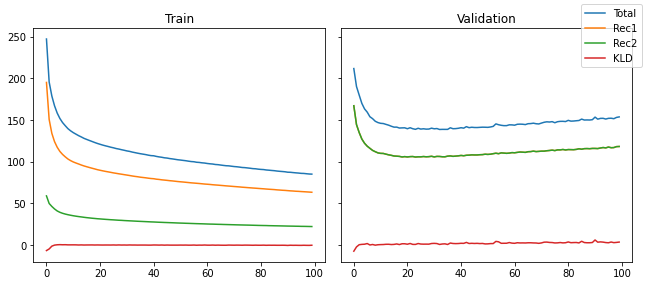

In [54]:
fig, ax = plt.subplots(ncols=2, sharex='all', sharey='all', figsize=(9, 4))

for i, label in enumerate(('Total', 'Rec1', 'Rec2', 'KLD')):
    ax[0].plot(train_loss[i], label=label)
    ax[1].plot(test_loss[i], label=label)
ax[0].set_title('Train')
ax[1].set_title('Validation')
fig.legend(*ax[0].get_legend_handles_labels())
fig.tight_layout()

In [19]:
z1 = np.asarray(latent1, dtype=np.float32)
z2 = np.asarray(latent2,dtype=np.float32)
np.save(PATH + 'latent_img.npy',z1)
np.save('latent_txt.npy',z2)
mu1 = np.asarray(mu1_data,dtype=np.float32)
mu2 = np.asarray(mu2_data,dtype=np.float32)
var1 = np.asarray(var1_data,dtype=np.float32)
var2 = np.asarray(var2_data,dtype=np.float32)
np.save(PATH + 'mu_img.npy',mu1)
np.save(PATH + 'mu_txt.npy',mu2)
np.save(PATH + 'var_img.npy',var1)
np.save(PATH + 'var_txt.npy',var2)

## Results

In [20]:
def pdist(sample_1, sample_2, eps=1e-5):
    """Compute the matrix of all squared pairwise distances. Code
    adapted from the torch-two-sample library (added batching).
    You can find the original implementation of this function here:
    https://github.com/josipd/torch-two-sample/blob/master/torch_two_sample/util.py
    Arguments
    ---------
    sample_1 : torch.Tensor or Variable
        The first sample, should be of shape ``(batch_size, n_1, d)``.
    sample_2 : torch.Tensor or Variable
        The second sample, should be of shape ``(batch_size, n_2, d)``.
    norm : float
        The l_p norm to be used.
    batched : bool
        whether data is batched
    Returns
    -------
    torch.Tensor or Variable
        Matrix of shape (batch_size, n_1, n_2). The [i, j]-th entry is equal to
        ``|| sample_1[i, :] - sample_2[j, :] ||_p``."""
    if len(sample_1.shape) == 2:
        sample_1, sample_2 = sample_1.unsqueeze(0), sample_2.unsqueeze(0)
    B, n_1, n_2 = sample_1.size(0), sample_1.size(1), sample_2.size(1)
    norms_1 = torch.sum(sample_1 ** 2, dim=-1, keepdim=True)
    norms_2 = torch.sum(sample_2 ** 2, dim=-1, keepdim=True)
    norms = (norms_1.expand(B, n_1, n_2)
             + norms_2.transpose(1, 2).expand(B, n_1, n_2))
    distances_squared = norms - 2 * sample_1.matmul(sample_2.transpose(1, 2))
    return torch.sqrt(eps + torch.abs(distances_squared)).squeeze()  # batch x K x latent


def NN_lookup(emb_h, emb):
    dist = pdist(emb.to(emb_h.device), emb_h)
    return dist, dist.argmin(dim=0)

In [22]:
vae, optimizer, epoch = load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])

In [55]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([img.to(device), txt[0].to(device)])
        dist, idx_h = NN_lookup(results['x_rec'][0], img)
        imgs_h = [CUB_test.CUBimg.dataset[j][0] for j in idx_h]
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

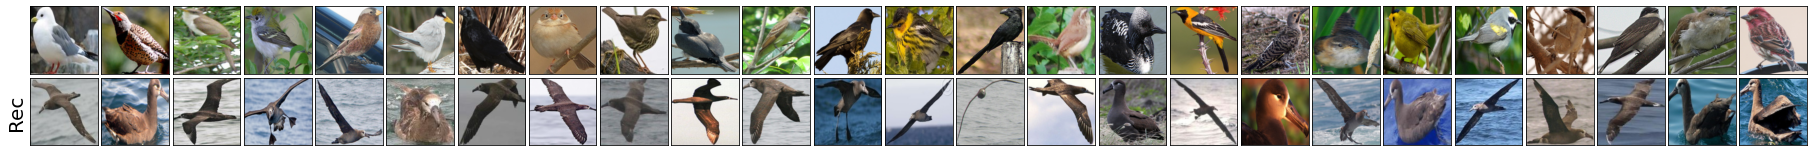

In [59]:
ncols = min(len(imgs_h), 25)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(25, 2))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.permute(1, 2, 0))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=20)
fig.tight_layout(pad=0)

In [61]:
sents_h = []
sents_emb = results['x_rec'][1].argmax(-1)
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

for i, sent_h in enumerate(sents_h):
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    print('     ', ' '.join(sent))
    print('Rec: ', sent_h)

      an eye catching bird that is white with gray wings and a downward curved yellow bill .
Rec:  this medium sized bird has gray wings and black wings and a long , orange bill .
      this bird is brown , black and gray in color , with a long and sharp beak .
Rec:  this bird is brown , white , and in in , with a very skinny skinny beak .
      this is a small brown bird its belly and breast are white , it has a yellow bill and a long tail feathers .
Rec:  this is a medium grey , bird in is bird and wings , also has rufous black beak and a and black .
      this small bird has a yellow crown and nape with a white belly and white wingbars .
Rec:  this small bird has a yellow crown and throat with a gray head and black wingbars .
      this bird has wings that are brown and has a yellow bill .
Rec:  this bird has wings that are brown and has a short bill .
      this white bird has a black nape and yellow beak and feet .
Rec:  this white bird has a black beak and black tarsus and feet .

#### Truth

In [ ]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

In [ ]:
sents_h = []
sents_emb = txt[0]
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

for i, sent_h in enumerate(sents_h):
    print(sent_h)
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    print(' '.join(sent))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=len(imgs), figsize=(40, 2))
for i, img in enumerate(imgs):
    ax[i].imshow(img[0].permute(1, 2, 0))
    print(img[1])
    ax[i].set_axis_off()
fig.tight_layout(pad=0)